## RFMV 세그멘테이션

### RFMV란? 기존의 RFM에 V(Variety, 카테고리 다양성)을 추가 채택, 고객이 플랫폼을 얼마나 폭넓게 활용하는지와 충성도에 대해 확인 가능
### 점수 기준? RFMV 각 컬럼별로 데이터 값을 기준으로 5분위수를 적용, 1~5점을 부여. 3점 이상이면 U(Up), 3점 미만이면 D(Down)로 분류

In [9]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 1. 판매 데이터 로드 (Onlinesales_info.csv)
sales_file = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"
sales = pd.read_csv(sales_file)

# 2. '거래날짜' 열을 datetime 형식으로 변환
sales['거래날짜'] = pd.to_datetime(sales['거래날짜'])

# 3. Recency 계산 (2020년 1월 1일 기준으로 마지막 거래 날짜까지의 일수)
reference_date = pd.Timestamp('2020-01-01')
sales['Recency'] = (reference_date - sales.groupby('고객ID')['거래날짜'].transform('max')).dt.days

# 4. 고객별 거래 횟수 계산 (Frequency)
frequency = sales.groupby('고객ID')['거래ID'].nunique()
sales['Frequency'] = sales['고객ID'].map(frequency)

# 5. 고객별 총 구매 금액 계산 후 정수 부분만 출력 (Monetary)
monetary = sales.groupby('고객ID').apply(
    lambda x: (x['수량'] * x['평균금액']).sum() + x['배송료'].sum()
).astype(int)
sales['Monetary'] = sales['고객ID'].map(monetary)

# 6. RFM 데이터프레임 생성 (고객별 한 행)
rfm_df = sales[['고객ID', 'Recency', 'Frequency', 'Monetary']].drop_duplicates('고객ID')

# 7. 고객 기본정보 파일 로드 및 RFM 데이터 병합
customer_file = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가"
customer_df = pd.read_csv(customer_file)
customer_df = pd.merge(customer_df, rfm_df, on='고객ID', how='left')

# 8. R, F, M 점수 계산 (5분위수 기준)
# Recency: 낮을수록 좋은 고객이므로, 낮은 Recency에 5점 부여 (역순)
customer_df['R_Score'] = pd.qcut(customer_df['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Frequency: 값이 클수록 좋은 고객이므로, 낮은 값은 1점, 높은 값은 5점 부여
customer_df['F_Score'] = pd.qcut(customer_df['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Monetary: 값이 클수록 좋은 고객이므로, 낮은 값은 1점, 높은 값은 5점 부여
customer_df['M_Score'] = pd.qcut(customer_df['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# 9. 구매 카테고리 다양성(V) 점수 계산 (5분위수 기준)
# '구매_카테고리_다양성' 열이 고객_df에 존재한다고 가정 (값이 클수록 다양성이 높으므로 높은 점수 부여)
customer_df['V_Score'] = pd.qcut(customer_df['구매_카테고리_다양성'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# 10. 결과 저장 (업데이트된 고객 파일 저장)
output_file = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가_with_RFM.csv"
customer_df.to_csv(output_file, index=False, encoding='utf-8-sig')


### RFMV 점수가 3점 이상이면 U(Up), 3점 미만이면 D(Down)로 분류하여 UUUU~DDDD까지 16개 조합을 생성

In [11]:
import pandas as pd

# 파일 경로
input_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\Customer_파생변수추가_with_RFM.csv"  # 입력 데이터 경로
output_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"  # 결과 저장 경로

# 데이터 불러오기
data = pd.read_csv(input_path)

# 스코어 변환 함수
def convert_score(value):
    if value in [1, 2]:
        return 'D'
    elif value in [3, 4, 5]:
        return 'U'
    else:
        return value  # 예외적으로 스코어 값이 위 조건에 해당하지 않을 경우 원래 값을 유지

# 각 스코어 컬럼에 변환 함수 적용 후 조합
data['RFMV_Score'] = (
    data['R_Score'].apply(convert_score) +
    data['F_Score'].apply(convert_score) +
    data['M_Score'].apply(convert_score) +
    data['V_Score'].apply(convert_score)
)

# 결과 저장
data.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"RFMV_Score 컬럼이 추가된 데이터가 저장되었습니다: {output_path}")


RFMV_Score 컬럼이 추가된 데이터가 저장되었습니다: C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv


## 각 클러스터들의 RFMV_Score 시각화

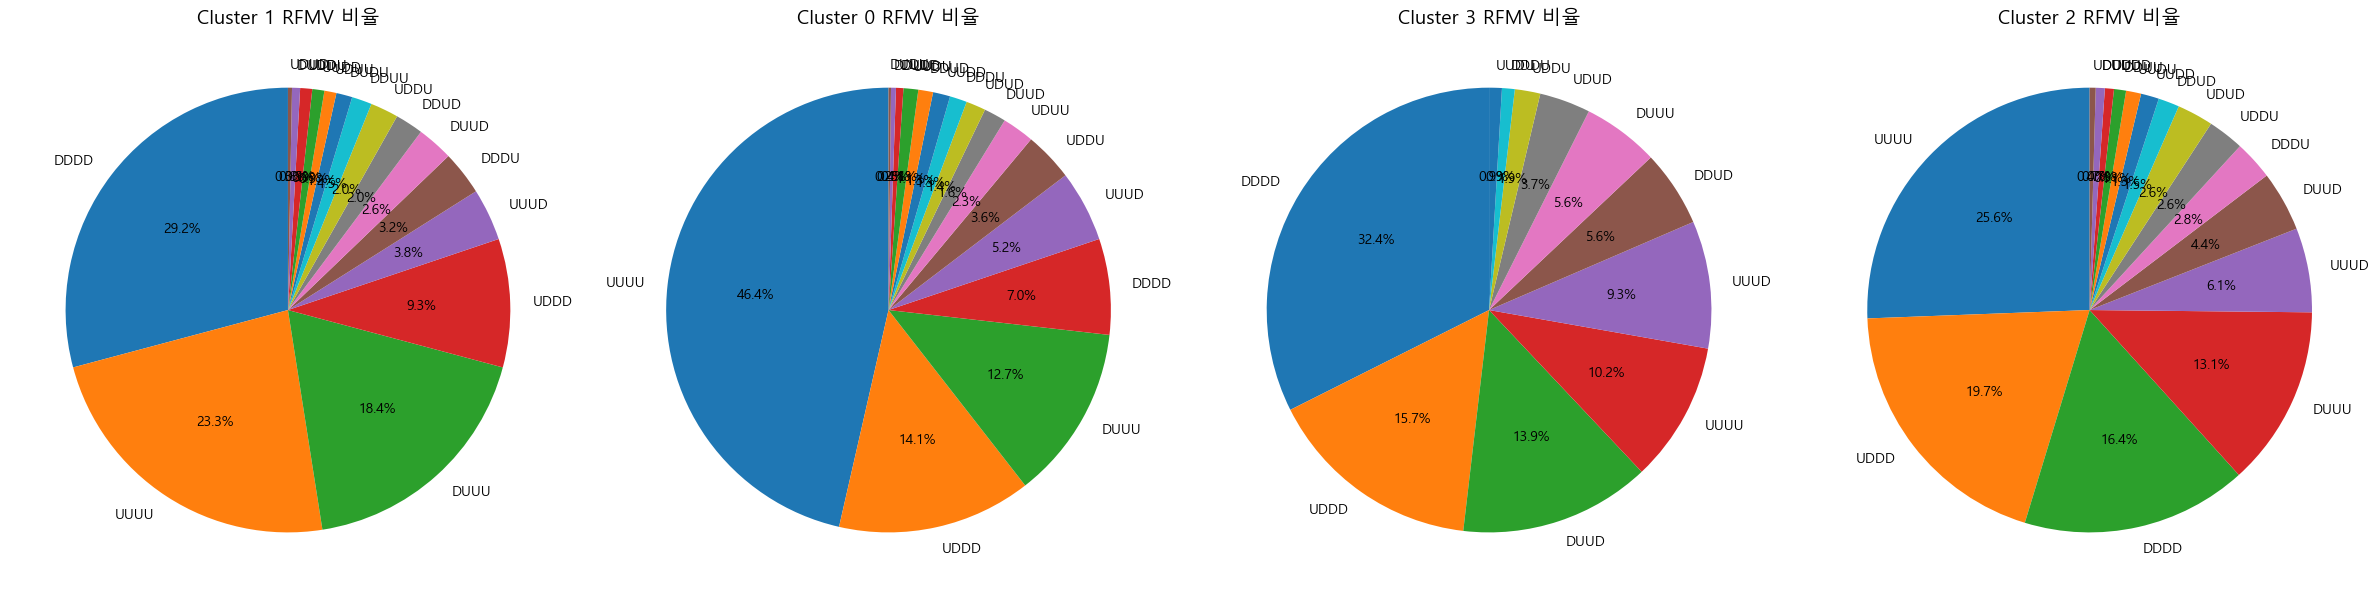

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False  

# 데이터 불러오기
file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"  # 입력 데이터 경로
data = pd.read_csv(file_path)

# 클러스터별 RFMV_Score 비율 계산
cluster_rfmv_distribution = data.groupby('Cluster')['RFMV_Score'].value_counts(normalize=True).rename('Percentage').reset_index()

# 시각화
clusters = data['Cluster'].unique()
num_clusters = len(clusters)

fig, axes = plt.subplots(1, num_clusters, figsize=(6 * num_clusters, 6))

for i, cluster in enumerate(clusters):
    # 각 클러스터 데이터 추출
    cluster_data = cluster_rfmv_distribution[cluster_rfmv_distribution['Cluster'] == cluster]
    
    # 원형 그래프 생성
    axes[i].pie(cluster_data['Percentage'], labels=cluster_data['RFMV_Score'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Cluster {cluster} RFMV 비율', fontsize=14)

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()


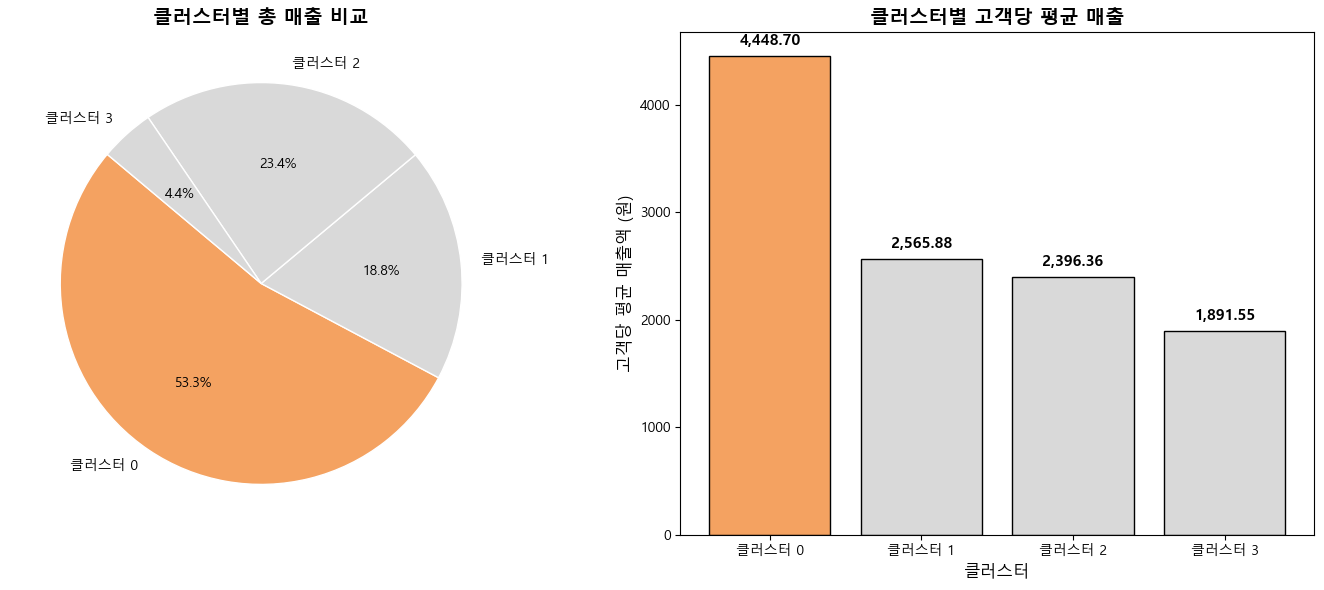

전체 매출: 4,670,794.62 원
클러스터 0 매출: 2,491,273.21 원 (53.34%)
클러스터 0 고객당 평균 매출: 4,448.70 원
클러스터 1 매출: 880,097.19 원 (18.84%)
클러스터 1 고객당 평균 매출: 2,565.88 원
클러스터 2 매출: 1,095,136.35 원 (23.45%)
클러스터 2 고객당 평균 매출: 2,396.36 원
클러스터 3 매출: 204,287.87 원 (4.37%)
클러스터 3 고객당 평균 매출: 1,891.55 원


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1. 데이터 로드
# =========================
customer_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"
sales_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"

customer_df = pd.read_csv(customer_file_path)
sales_df = pd.read_csv(sales_file_path)

# =========================
# 2. 매출액 계산
# =========================
if '매출액' not in sales_df.columns:
    sales_df['매출액'] = sales_df['수량'] * sales_df['평균금액']

# =========================
# 3. 클러스터별 매출 및 고객당 평균 매출 계산
# =========================
cluster_sales = {}
cluster_customer_counts = {}

for cluster_id in range(4):  # 클러스터 0~3
    cluster_customers = customer_df[customer_df['Cluster'] == cluster_id]['고객ID']
    cluster_sales[cluster_id] = sales_df[sales_df['고객ID'].isin(cluster_customers)]['매출액'].sum()
    cluster_customer_counts[cluster_id] = cluster_customers.nunique()

# 전체 매출 계산
total_sales = sales_df['매출액'].sum()
cluster_ratios = {cluster: (sales / total_sales) * 100 for cluster, sales in cluster_sales.items()}

# 클러스터별 고객당 평균 매출 계산
cluster_avg_sales = {cluster: cluster_sales[cluster] / cluster_customer_counts[cluster] for cluster in cluster_sales.keys()}

# =========================
# 4. 시각화 (파이 차트 + 막대 그래프)
# =========================
plt.rcParams["font.family"] = "Malgun Gothic"  # 한글 폰트 설정
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1행 2열로 출력

# ---- (왼쪽) 클러스터별 매출 비율 (파이 차트) ----
colors = ['#f4a261' if cluster == 0 else '#d9d9d9' for cluster in cluster_sales.keys()]

axes[0].pie(
    cluster_ratios.values(),
    labels=[f"클러스터 {i}" for i in cluster_ratios.keys()],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
axes[0].set_title("클러스터별 총 매출 비교", fontsize=14, fontweight='bold')

# ---- (오른쪽) 클러스터별 고객당 평균 매출 (막대 그래프) ----
bars = axes[1].bar(
    [f"클러스터 {i}" for i in cluster_avg_sales.keys()],
    cluster_avg_sales.values(),
    color=colors, edgecolor='black'
)

# 각 막대 위에 값 표시
for bar, avg_sales in zip(bars, cluster_avg_sales.values()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                 f"{avg_sales:,.2f}", ha='center', fontsize=11, fontweight='bold')

axes[1].set_title("클러스터별 고객당 평균 매출", fontsize=14, fontweight='bold')
axes[1].set_xlabel("클러스터", fontsize=12)
axes[1].set_ylabel("고객당 평균 매출액 (원)", fontsize=12)

plt.tight_layout()
plt.show()

# =========================
# 5. 결과 출력
# =========================
print("전체 매출: {:,.2f} 원".format(total_sales))
for cluster, sales in cluster_sales.items():
    print(f"클러스터 {cluster} 매출: {sales:,.2f} 원 ({cluster_ratios[cluster]:.2f}%)")
    print(f"클러스터 {cluster} 고객당 평균 매출: {cluster_avg_sales[cluster]:,.2f} 원")


### -> 총 매출이 전체 매출의 53.3%를 차지하고 고객당 평균 매출이 타 클러스터에 비해 최대 135% 높은 **클러스터0**의 조합 UUUU, UDDD, DUUU, UUUD, DDDD에 대해 세부 전략 수립

## UUUU

#### 모든 수치에서 높은등급에 해당되는 고객군, 품목고급화를 통한 고비용 마케팅 필요

➔ 수, 금요일에 거래 횟수가 많은 모습을 보여주고 있으며 Apparel, Nest-USA, Office 순으로 거래 횟수가 많은 모습

➔ 평균 단가가 비싼 카테고리에 대한 구매도 적지않게 이루어지고 있는 모습

## 솔루션

거래 횟수가 많은 수, 금요일에 일정 수요가 있으면서 평균 단가가 비싼 카테고리(Nest-USA, Nest, Bags)에 해당하는 쿠폰을 제공

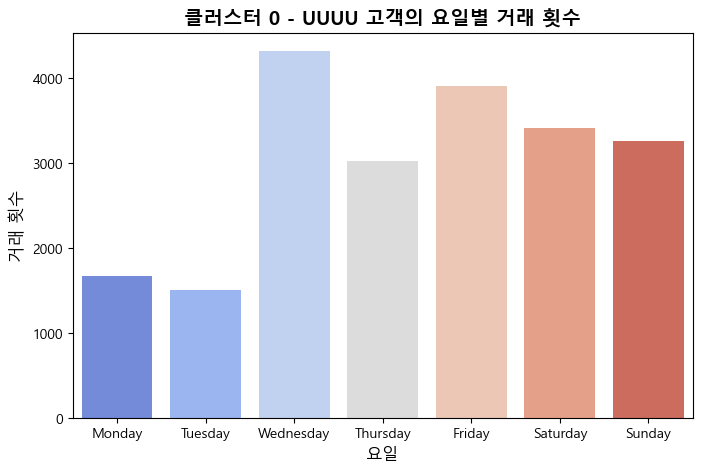

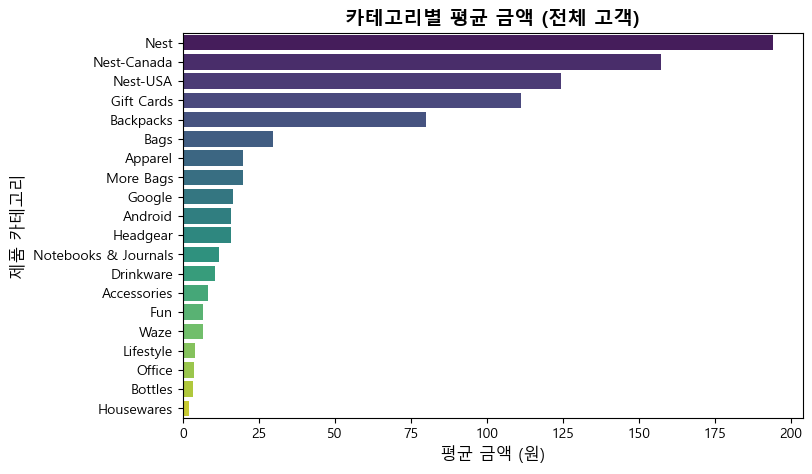

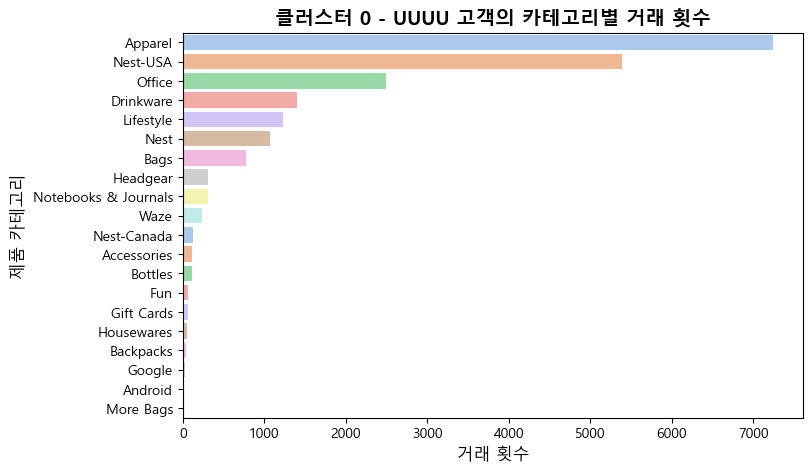

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# =========================
# 1. 데이터 로드
# =========================
customer_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"
sales_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"

customer_df = pd.read_csv(customer_file_path)
sales_df = pd.read_csv(sales_file_path)

# =========================
# 2. 클러스터 0 + UUUU 고객 필터링
# =========================
cluster_0_customers = customer_df[customer_df['Cluster'] == 0]
uuuu_customers = cluster_0_customers[cluster_0_customers['RFMV_Score'] == 'UUUU']['고객ID']
uuuu_sales = sales_df[sales_df['고객ID'].isin(uuuu_customers)].copy()

# =========================
# 3. 날짜 변환
# =========================
sales_df['거래날짜'] = pd.to_datetime(sales_df['거래날짜'], errors='coerce')
uuuu_sales['거래날짜'] = pd.to_datetime(uuuu_sales['거래날짜'], errors='coerce')

# =========================
# 4. (1) 클러스터 0 + UUUU 고객의 요일별 거래 횟수
# =========================
uuuu_sales['요일'] = uuuu_sales['거래날짜'].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
uuuu_weekday_counts = uuuu_sales['요일'].value_counts().reindex(day_order).fillna(0)

plt.figure(figsize=(8, 5))
sns.barplot(x=uuuu_weekday_counts.index, y=uuuu_weekday_counts.values, palette="coolwarm")
plt.title("클러스터 0 - UUUU 고객의 요일별 거래 횟수", fontsize=14, fontweight='bold')
plt.xlabel("요일", fontsize=12)
plt.ylabel("거래 횟수", fontsize=12)
plt.show()

# =========================
# 5. (2) 카테고리별 평균 금액 (전체 고객 기준)
# =========================
category_avg_price = sales_df.groupby('제품카테고리')['평균금액'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(y=category_avg_price.index, x=category_avg_price.values, palette="viridis")
plt.title("카테고리별 평균 금액 (전체 고객)", fontsize=14, fontweight='bold')
plt.xlabel("평균 금액 (원)", fontsize=12)
plt.ylabel("제품 카테고리", fontsize=12)
plt.show()

# =========================
# 6. (3) 클러스터 0 + UUUU 고객의 카테고리별 거래 횟수
# =========================
uuuu_category_counts = uuuu_sales['제품카테고리'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(y=uuuu_category_counts.index, x=uuuu_category_counts.values, palette="pastel")
plt.title("클러스터 0 - UUUU 고객의 카테고리별 거래 횟수", fontsize=14, fontweight='bold')
plt.xlabel("거래 횟수", fontsize=12)
plt.ylabel("제품 카테고리", fontsize=12)
plt.show()


## UDDD

#### R은 U에 해당되지만 다른 수치들이 모두 낮은 등급인 것을 보아 재참여 초기단계의 고객에 해당되며 재구매 유도를 위한 구매 평균 주기를 이용한 마케팅 필요

➔ 대부분의 평균 주기가 2일~22일 사이에 분포되어 있음

➔ 주기 평균은 약17일, 3사분위수는 약22일로 나타남

## 솔루션

과도한 마케팅 압박을 줄이고 긍정적인 사용자 경험을 제공하기 위해 3사분위수인 22일을 이용, 마지막 구매일로부터 22일이 넘어가는 시점에 리마인드 메세지 혹은 앱푸쉬 알림

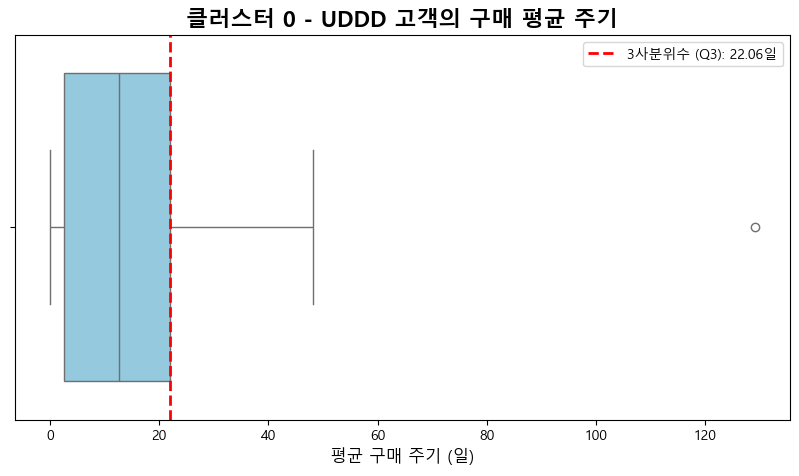

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# =========================
# 1. 데이터 로드
# =========================
customer_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"
sales_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"

customer_df = pd.read_csv(customer_file_path)
sales_df = pd.read_csv(sales_file_path)

# =========================
# 2. 클러스터 0 + UDDD 고객 필터링
# =========================
cluster_0_customers = customer_df[customer_df['Cluster'] == 0]
uddd_customers = cluster_0_customers[cluster_0_customers['RFMV_Score'] == 'UDDD']['고객ID']
uddd_sales = sales_df[sales_df['고객ID'].isin(uddd_customers)].copy()

# =========================
# 3. 날짜 변환
# =========================
uddd_sales['거래날짜'] = pd.to_datetime(uddd_sales['거래날짜'], errors='coerce')

# =========================
# 4. 클러스터 0 - UDDD 고객의 구매 주기 계산
# =========================
uddd_sales = uddd_sales.sort_values(['고객ID', '거래날짜'])
uddd_sales['구매_주기'] = uddd_sales.groupby('고객ID')['거래날짜'].diff().dt.days

# 평균 구매 주기 계산
avg_purchase_interval = uddd_sales.groupby('고객ID')['구매_주기'].mean().dropna()
avg_purchase_interval_nonzero = avg_purchase_interval[avg_purchase_interval > 0]

# 3사분위수(Q3) 계산
q3 = avg_purchase_interval_nonzero.quantile(0.75)

# =========================
# 5. 박스플롯 시각화
# =========================
plt.figure(figsize=(10, 5))
sns.boxplot(x=avg_purchase_interval_nonzero, color="skyblue")

# 3사분위수(Q3) 선 표시
plt.axvline(q3, color='red', linestyle='--', linewidth=2, label=f'3사분위수 (Q3): {q3:.2f}일')

# 제목 및 라벨 설정
plt.title("클러스터 0 - UDDD 고객의 구매 평균 주기", fontsize=16, fontweight='bold')
plt.xlabel("평균 구매 주기 (일)", fontsize=12)
plt.legend()

# 그래프 표시
plt.show()


## DUUU

#### 복귀 유도를 위한 이탈 전 구매 이력에 대한 분석

➔ DUUU 고객층은 마지막 구매 이후 시간이 지난 고객들로, 복귀를 위해 Apparel, Nest-USA, Office, Drinkware, Lifestyle 제품을 중심으로 마케팅을 강화할 필요 O

## 솔루션

구매가 많았던 Apparel, Nest-USA, Office, Drinkware, Lifestyle 카테고리 위주로 웰컴백 쿠폰 제공, 개인화된 메시지 발송

DUUU 고객들의 마지막 구매일 기준 경과일수:
        고객ID       거래날짜  기준일_경과일수
0  USER_0006 2019-06-25       190
1  USER_0075 2019-06-27       188
2  USER_0107 2019-02-09       326
3  USER_0156 2019-07-20       165
4  USER_0183 2019-02-03       332
DUUU 고객들의 제품 카테고리별 구매수:
       제품카테고리   구매수
2     Apparel  1303
15   Nest-USA  1042
17     Office   569
6   Drinkware   277
12  Lifestyle   219


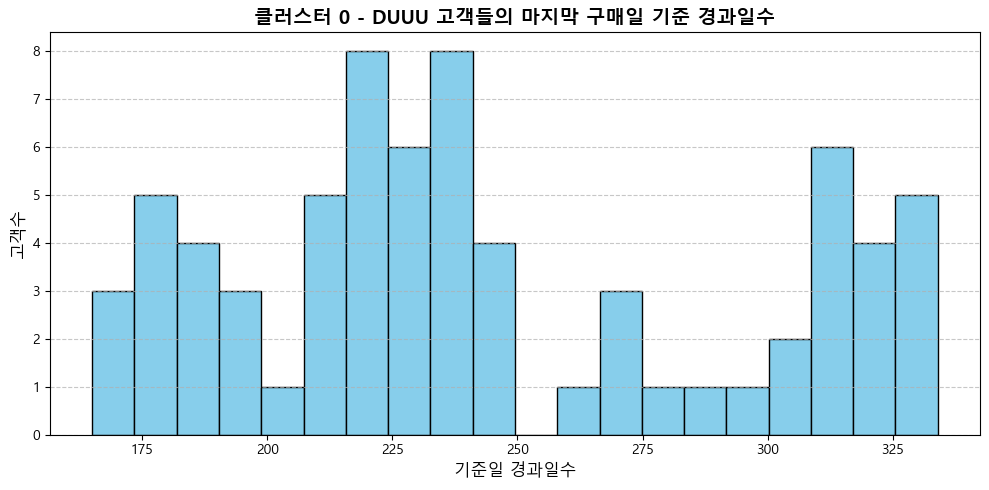

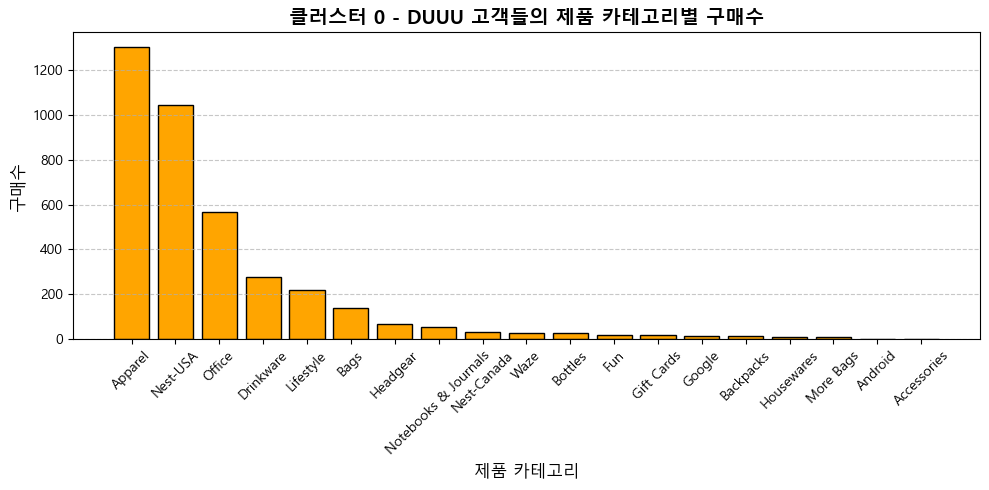

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# =========================
# 1. 데이터 로드
# =========================
customer_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"
sales_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"

customer_df = pd.read_csv(customer_file_path)
sales_df = pd.read_csv(sales_file_path)

# =========================
# 2. 클러스터 0 + DUUU 고객 필터링
# =========================
cluster_0_customers = customer_df[customer_df['Cluster'] == 0]
duuu_customers = cluster_0_customers[cluster_0_customers['RFMV_Score'] == 'DUUU']['고객ID']
duuu_sales = sales_df[sales_df['고객ID'].isin(duuu_customers)].copy()

# =========================
# 3. 마지막 구매일과 기준일 차이 계산
# =========================
기준일 = datetime(2020, 1, 1)

# 날짜 형식 변환
duuu_sales['거래날짜'] = pd.to_datetime(duuu_sales['거래날짜'], errors='coerce')

# 고객별 마지막 구매일 계산
last_purchase = duuu_sales.groupby('고객ID')['거래날짜'].max().reset_index()
last_purchase['기준일_경과일수'] = (기준일 - last_purchase['거래날짜']).dt.days

print("DUUU 고객들의 마지막 구매일 기준 경과일수:")
print(last_purchase.head())

# =========================
# 4. 과거 구매 패턴 분석
# =========================
# 구매 빈도 계산
purchase_frequency = duuu_sales.groupby('고객ID').size().reset_index(name='구매횟수')

# 제품 카테고리별 구매 빈도
category_analysis = duuu_sales.groupby('제품카테고리').size().reset_index(name='구매수')
category_analysis = category_analysis.sort_values(by='구매수', ascending=False)

print("DUUU 고객들의 제품 카테고리별 구매수:")
print(category_analysis.head())

# =========================
# 5. 시각화
# =========================
plt.rcParams["font.family"] = "Malgun Gothic"  # 한글 폰트 설정

# ---- (1) 마지막 구매일 기준 경과일수 시각화 ----
plt.figure(figsize=(10, 5))
plt.hist(last_purchase['기준일_경과일수'], bins=20, color='skyblue', edgecolor='black')
plt.title('클러스터 0 - DUUU 고객들의 마지막 구매일 기준 경과일수', fontsize=14, fontweight='bold')
plt.xlabel('기준일 경과일수', fontsize=12)
plt.ylabel('고객수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---- (2) 제품 카테고리별 구매수 시각화 ----
plt.figure(figsize=(10, 5))
plt.bar(category_analysis['제품카테고리'], category_analysis['구매수'], color='orange', edgecolor='black')
plt.title('클러스터 0 - DUUU 고객들의 제품 카테고리별 구매수', fontsize=14, fontweight='bold')
plt.xlabel('제품 카테고리', fontsize=12)
plt.ylabel('구매수', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## UUUD

#### 구매 카테고리 다양화를 위한 연관분석 등 고비용 마케팅 필요

➔ UUUD 고객층의 주요 구매 카테고리가 NestUSA, Apparel인 것을 확인.

➔ 연관분석을 통해 같이 구매한 제품 카테고리의 비율을 확인함.

➔ Nest-USA, Apparel와 함께 자주 구매된 카테고리가 Office, Drinkware, Lifestyle임을 확인.

## 솔루션

UUUD 내 인기 카테고리인 Nest-USA와 함께 자주 구매된 다른 카테고리 상품(Apparel, Office, Drinkware, Lifestyle)을 추천

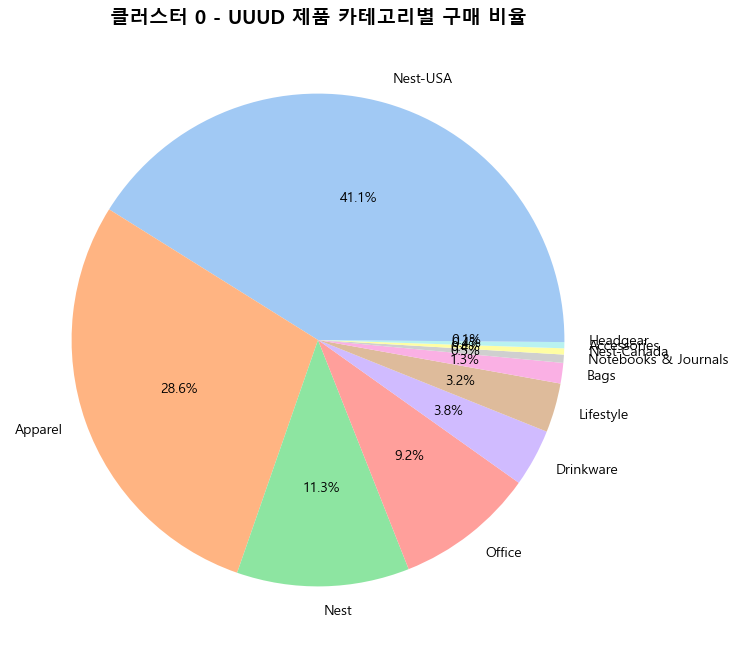

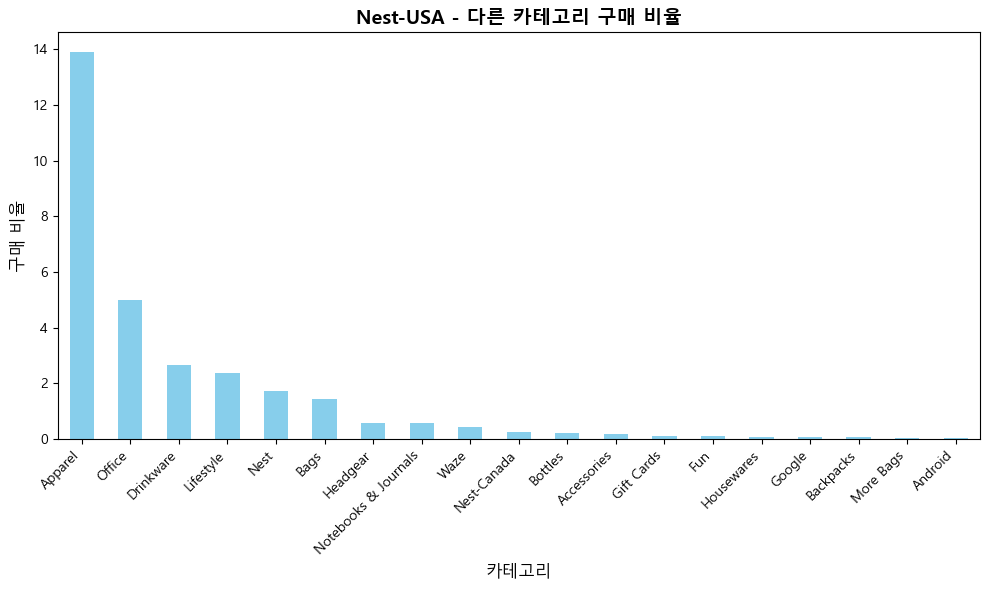

Nest-USA - 다른 카테고리 구매 비율:
제품카테고리
Apparel                 13.907937
Office                   5.011905
Drinkware                2.676190
Lifestyle                2.361111
Nest                     1.726190
Bags                     1.446032
Headgear                 0.594444
Notebooks & Journals     0.575397
Waze                     0.434127
Nest-Canada              0.247619
Bottles                  0.209524
Accessories              0.180159
Gift Cards               0.126190
Fun                      0.123810
Housewares               0.096032
Google                   0.082540
Backpacks                0.068254
More Bags                0.034127
Android                  0.034127
Name: count, dtype: float64


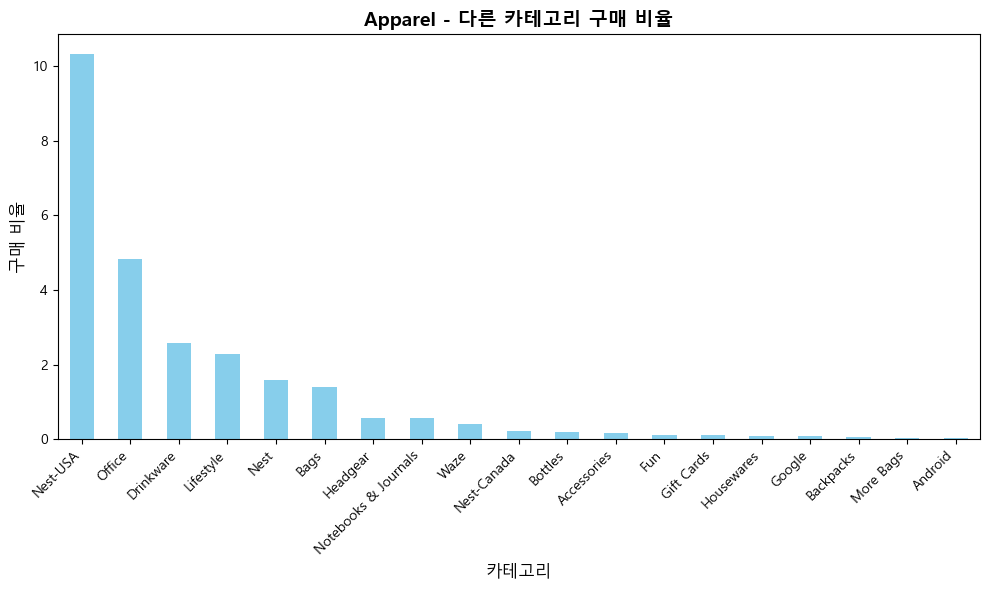

Apparel - 다른 카테고리 구매 비율:
제품카테고리
Nest-USA                10.339380
Office                   4.826153
Drinkware                2.580499
Lifestyle                2.287226
Nest                     1.595616
Bags                     1.395314
Headgear                 0.572184
Notebooks & Journals     0.557823
Waze                     0.411943
Nest-Canada              0.229781
Bottles                  0.201814
Accessories              0.170824
Fun                      0.118670
Gift Cards               0.115646
Housewares               0.091459
Google                   0.078609
Backpacks                0.065004
More Bags                0.034769
Android                  0.032502
Name: count, dtype: float64


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# =========================
# 1. 데이터 로드
# =========================
customer_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"
sales_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"

customer_df = pd.read_csv(customer_file_path)
sales_df = pd.read_csv(sales_file_path)

# =========================
# 2. 클러스터 0 + UUUD 고객 필터링
# =========================
cluster_0_customers = customer_df[customer_df['Cluster'] == 0]
uuud_customers = cluster_0_customers[cluster_0_customers['RFMV_Score'] == 'UUUD']['고객ID']
uuud_sales = sales_df[sales_df['고객ID'].isin(uuud_customers)].copy()

# =========================
# 3. 클러스터 0 - UUUD 제품 카테고리별 구매 횟수 (원형 그래프)
# =========================
category_counts = uuud_sales['제품카테고리'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("클러스터 0 - UUUD 제품 카테고리별 구매 비율", fontsize=14, fontweight='bold')
plt.show()

# =========================
# 4. 전체 고객 데이터 로드 및 전처리
# =========================
df = pd.read_csv(sales_file_path)

# 고객ID별로 제품 카테고리 구매 내역 생성
if '고객ID' in df.columns and '제품카테고리' in df.columns:
    basket = df.groupby(['고객ID', '제품카테고리'])['제품카테고리'].count().unstack().fillna(0)
    basket = basket.applymap(lambda x: 1 if x > 0 else 0)
else:
    raise ValueError("데이터에 '고객ID' 또는 '제품카테고리' 컬럼이 없습니다.")

# =========================
# 5. 특정 제품과 같이 구매된 카테고리 비율 (Nest-USA & Apparel)
# =========================
categories = ['Nest-USA', 'Apparel']
category_purchase_ratio = {}

for category in categories:
    # 해당 카테고리를 구매한 고객 ID 리스트
    customers_who_bought_category = df[df['제품카테고리'] == category]['고객ID'].unique()

    # 해당 고객들이 구매한 다른 카테고리들 추출
    other_categories = df[df['고객ID'].isin(customers_who_bought_category) & (df['제품카테고리'] != category)]

    # 각 다른 카테고리별 구매 비율 계산
    category_counts = other_categories['제품카테고리'].value_counts()
    total_customers = len(customers_who_bought_category)

    # 비율 계산: 각 카테고리 구매 고객 수 / 해당 카테고리 구매 고객 수
    category_purchase_ratio[category] = category_counts / total_customers

# =========================
# 6. 비율 그래프 시각화 (Nest-USA & Apparel)
# =========================
for category, ratio_data in category_purchase_ratio.items():
    plt.figure(figsize=(10, 6))
    ratio_data_sorted = ratio_data.sort_values(ascending=False)  # 비율이 높은 순으로 정렬
    ratio_data_sorted.plot(kind='bar', color='skyblue')
    
    plt.title(f"{category} - 다른 카테고리 구매 비율", fontsize=14, fontweight='bold')
    plt.xlabel('카테고리', fontsize=12)
    plt.ylabel('구매 비율', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 비율 출력
    print(f"{category} - 다른 카테고리 구매 비율:")
    print(ratio_data_sorted)
    print("="*50)


## DDDD

#### 대부분 이탈 고객, 과거 구매 제품 분석 등 저비용 마케팅 필요

➔ 과거에 Apparel, Nest-USA, Office 카테고리의 구매 횟수가 높았던 모습

## 솔루션

거래가 많았던 상품(Apparel, Nest-USA, Office)을 알고리즘에 노출 혹은 추천 메세지 보내기

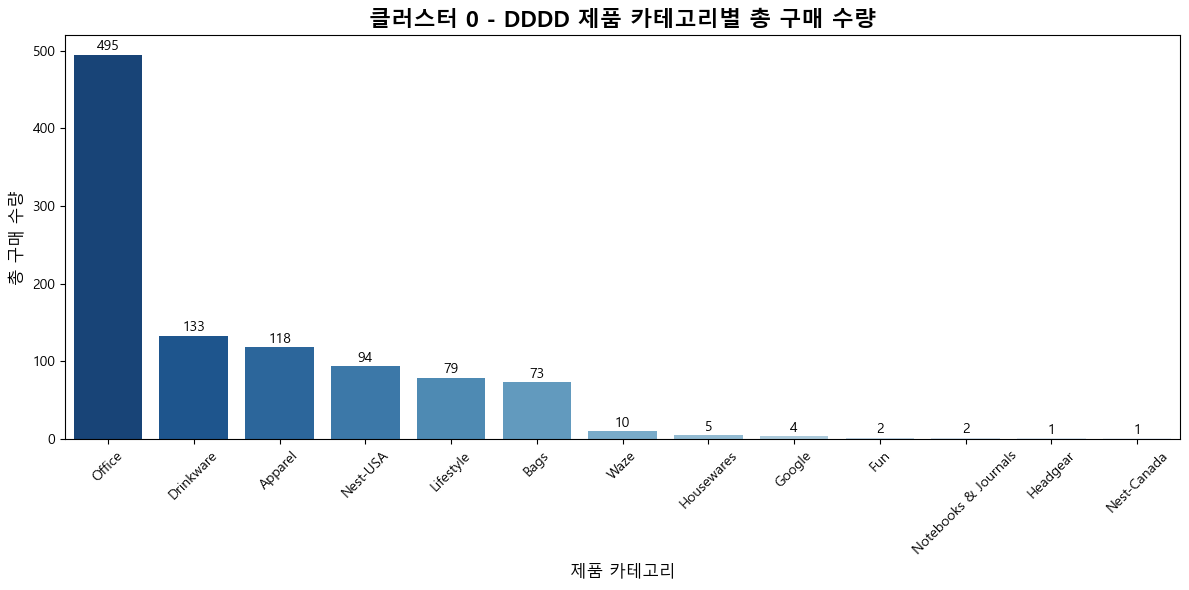

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. 데이터 로드
# =========================
customer_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\전처리\updated_data_with_rfmv_score.csv"
sales_file_path = r"C:\Users\Jimin\Desktop\project\ecommerce\raw\Onlinesales_info.csv"

customer_df = pd.read_csv(customer_file_path)
sales_df = pd.read_csv(sales_file_path)

# =========================
# 2. 클러스터 0 + DDDD 고객 필터링
# =========================
cluster_0_customers = customer_df[customer_df['Cluster'] == 0]
dddd_customers = cluster_0_customers[cluster_0_customers['RFMV_Score'] == 'DDDD']['고객ID']
dddd_sales = sales_df[sales_df['고객ID'].isin(dddd_customers)].copy()

# =========================
# 3. 제품 카테고리별 구매 수량 계산
# =========================
category_quantity = dddd_sales.groupby('제품카테고리')['수량'].sum().reset_index()
category_quantity = category_quantity.sort_values(by='수량', ascending=False)  # 높은 순으로 정렬

# =========================
# 4. 시각화: 제품 카테고리별 구매 수량
# =========================
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=category_quantity, x='제품카테고리', y='수량', palette='Blues_r')
plt.title('클러스터 0 - DDDD 제품 카테고리별 총 구매 수량', fontsize=16, fontweight='bold')
plt.xlabel('제품 카테고리', fontsize=12)
plt.ylabel('총 구매 수량', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# 막대 위에 구매 수량 표시
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{int(height)}', (bar.get_x() + bar.get_width() / 2, height + 2),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
